In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import pad
from safetensors.torch import load_file

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_file_path = "../GUE_finetuned_models/DNABERT2_EMP_H3_model/model.safetensors"
loaded_state_dict = load_file(model_file_path, device=device)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [5]:
from lrp import checkpoint_hook, lrp_engine

In [6]:
for layer_module in model.bert.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [7]:
data_path = "../GUE/EMP/H3/test.csv"
batch_size = 500
batch_start = 0
with open(data_path, "r") as fileIn:
    fileIn.readline()
    dna = []
    for _ in range(batch_start):
        fileIn.readline()
    for _ in range(batch_size):
        line = fileIn.readline()
        line = line.split(",")[0].strip()
        dna.append(line)

inputs = sorted([ tokenizer(x, return_tensors = 'pt')["input_ids"] for x in dna ], key=lambda t: t.shape[-1], reverse=True)


In [8]:
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_f

In [9]:
in_adj_list = None
out_adj_list = None
topo_exec_order = None
fcn_map = None
agg_checkpoint_vals = None

In [10]:
outputs : torch.Tensor = model(inputs[0].to(device))

In [11]:
# Single example test
logits = outputs[0]
hidden_states = outputs.hidden_states
checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)


In [12]:
checkpoint_vals1, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)

In [13]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals, checkpoint_vals1)
]

[tensor(1.6964e-10, device='cuda:0'),
 tensor(2.6473e-12, device='cuda:0'),
 tensor(8.7130e-13, device='cuda:0'),
 tensor(1.1052e-12, device='cuda:0'),
 tensor(8.9848e-13, device='cuda:0'),
 tensor(7.4342e-12, device='cuda:0'),
 tensor(4.6669e-11, device='cuda:0'),
 tensor(7.4996e-11, device='cuda:0'),
 tensor(4.4547e-11, device='cuda:0'),
 tensor(7.7709e-10, device='cuda:0'),
 tensor(9.9911e-10, device='cuda:0'),
 tensor(4.4147e-10, device='cuda:0')]

In [12]:
# AI-generated, needed quick tooling
# Basically adding two matrices together if dim 0 is variable, but dim 1 is constant.
def accumulate_variable_matrix(accumulator, new_matrix):
    # Get current shapes
    acc_rows, acc_cols = accumulator.shape
    new_rows, new_cols = new_matrix.shape

    # Determine target size (assume row counts always match, or adapt as needed)
    target_rows = max(acc_rows, new_rows)

    # Expand accumulator if needed
    if acc_rows < target_rows:
        pad_rows = target_rows - acc_rows
        accumulator = torch.cat([accumulator, torch.zeros(pad_rows, acc_cols, device=accumulator.device, dtype=accumulator.dtype)], dim=0)

    # Expand new_matrix if needed
    if new_rows < target_rows:
        pad_rows = target_rows - new_rows
        new_matrix = torch.cat([new_matrix, torch.zeros(pad_rows, new_cols, device=accumulator.device, dtype=accumulator.dtype)], dim=0)

    # Now both matrices have same shape, so they can be added
    accumulator += new_matrix
    return accumulator

In [13]:
from tqdm import tqdm
for i in tqdm(range(200)):
    inputs = tokenizer(dna[i], return_tensors = 'pt')["input_ids"]
    outputs : torch.Tensor = model(inputs.to(device))
    logits = outputs[0]
    hidden_states = outputs.hidden_states
    checkpoint_vals, out_adj_list, topo_exec_order, fcn_map = lrp_engine(hidden_states.half(), out_adj_list, topo_exec_order, fcn_map)

    if agg_checkpoint_vals is None:
        agg_checkpoint_vals = checkpoint_vals
    else:
        for j in range(len(agg_checkpoint_vals)):
            accumulate_variable_matrix(agg_checkpoint_vals[j], checkpoint_vals[j])
            # agg_checkpoint_vals[j] += checkpoint_vals[j]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.17it/s]


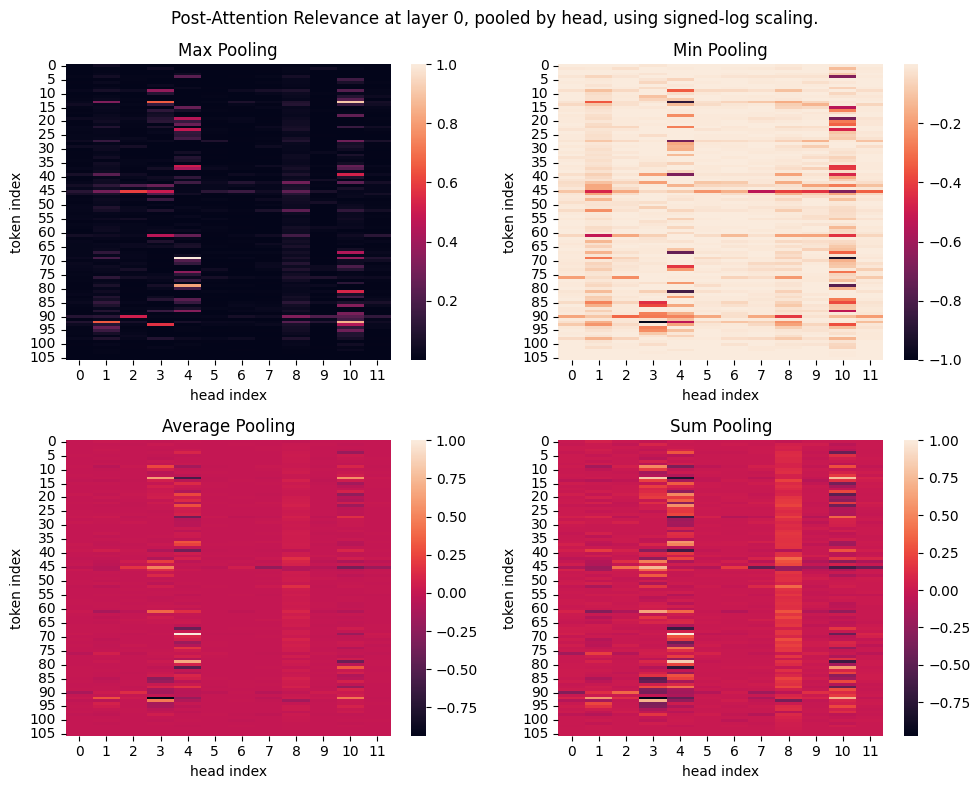

In [16]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 0

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(agg_checkpoint_vals[layer_ind], 0))
    lrp_shape = checkpoint_output.shape
    raw_heatmap = checkpoint_output.view((lrp_shape[-2], lrp_shape[-1]))
    normed = raw_heatmap.sign() * torch.log1p(raw_heatmap.abs())
    normed /= torch.max(normed.abs())
    sns.heatmap(normed.cpu(), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2 - 1:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head, using signed-log scaling.")
fig.tight_layout()

plt.show()

In [20]:
peak = torch.cuda.max_memory_allocated()
print("Peak memory (bytes):", peak)

Peak memory (bytes): 8015348736
